# Degeneration

This Notebook contains an hands-on explanation and example of the degeneration-algorithm. 

First, we do a short sanity and healthcheck of the components, we will then go forth to the remote-degeneration for the trasi-webinterface and finalize this notebook with a local-degeneration which is feasible for any given model. 

For a more detailed system-setup see the readme.md in this folder. 

To summarize you need to have the following:

* required (common) Python libraries installed
* real streetsign-images as ppms 
* the .py files of this repository
* for remote: internet-connection and further libraries (e.g. JSON)
* for local: a tensorflow model in reach

This notebook wil mostly replicate the Degeneration.py file and enrich it with information gained throughout the process. 

### Imports
There are several imports required: we need different *common* foreign libraries such as numpy and scipy to work with our images the way we want. These are used for loading the ppm' images and alternation. Time is required for the remote-algorithm and a wait-time.

There are further *hidden libraries* in the other .py files. For a global summary and versions, consult the readme.

Our *homebrew* libraries consist of the following:

1. LabelDictionary: simple dictionary for the GTSRB-classes for better readable data.
2. Training: Contains the training of our GTSRB-Model used in local degeneration, and some helper methods for loading and saving the model. 
3. Scorer: Contains the methods required to send a bytearray to the trasi-webinterface and recieve the score.
4. ImageHelper: Contains some general methods for altering and saving images.
5. Feeder: Contains some methods to put a bytearray-image into our local-model.

In [1]:
# Foreign Imports
import numpy as np
import matplotlib.pyplot as plt
from scipy import misc as scipyMisc
from scipy import ndimage
import time
#from PIL import Image
# Homebrew Files
import Training 
import Scorer 
import ImageHelper as ImgHelper
import Feeder
import LabelDictionary as Labels

## (Remote) loading and scoring images
First, we load the image we want to alter and look at it, if it's a good image. 

For the algorithm, we need an image that **is** a real street sign and gets a good score. Most of our images originate from the GTSRB-Test-Set. 

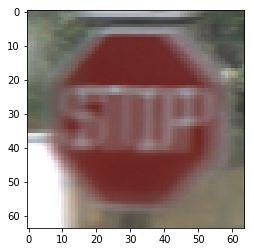

In [2]:
#Load resource - resource folder with ppm images is needed in Medusa folder
remoteImg =ImgHelper.load_ppm_image("images/TestStop.ppm")
plt.imshow(remoteImg)

The remoteImg is a (64x64x3) array, and the load_ppm_image does a simple bilinear interpolation. 

This sometimes yields *blurry* results for a human, which is caused by a double interpolation by your jupyter-notebook (the image above is not *really* 64 x 64, but much larger). However, it's not that important what we think, and it's more important what the AI says. 

We check this, by using our **scorer**.

In [3]:
response = Scorer.send_ppm_image(remoteImg)
print("Status:",response.status_code)
# the respone.json() gives the full json-result, comment this in for your own liking
# print(response.json())
print(response.json()[0])

Status: 200
{'class': 'Stoppschild', 'confidence': 0.97586221}


That's all the remote-setup we need to do. 

Always make sure to sanity-check your images. 

We've faced several problems using images originated in the training set: we guess that there are strong cases of overfitting in the real-AI. As the AI remembers the images, instead of actually rating it, we had a very hard time altering them.

This is a remote-only problem. 

## (Local) loading and scoring images and the model
Now we load the image we want to score locally, load the AI and score the image. 

We've chosen a different picture then above. 

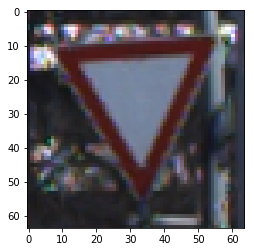

In [4]:
#Load resource - resource folder with ppm images is needed in Medusa folder
img = ImgHelper.load_ppm_image("images/TestGiveWay.ppm")
plt.imshow(img)
plt.show()

Now we load and inspect our local AI.

The following is a keras summary of our Tensorflow Model. 

The model needs to be in the folder. It's possible to use different models aswell, if their *predict* behaviour is the same or you implement a simple helper-method. 

In [8]:
# Load model - Trained model is needed in Medusa folder
aphrodite = Training.load_model('Aphrodite.h5')
aphrodite.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 62, 62, 32)        9248      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 31, 31, 64)        18496     
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 29, 29, 128)       73856     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 14, 14, 128)       0         
__________

We've used several models throughout the process. There have been bigger and smaller ones, this one achieved a good performance in the test set (~96%) but strongly overfits with the training data.

The Aphrodite-Model is not comparable to the Remote-AI for several reasons:

* The Trasi-AI seems to have less classes (10 less)
* It's unlikely to guess the same layers
* It's unlikely to prepare images the same way for prediction

Therefore the results of the local-degeneration do not fool the remote-ai and vice-versa. 

To summarize this, the AI's seems to have the same strengths but totally different weaknesses. 

Let's look how we inspect our prediction and close our loading chapter:

To predict a single image, we need to give the model an array containg the image. We need to do this because tensorflow-models want to batch-process images. 

We can access the best scores and class via the *argmax* function and print it out

In [9]:
# Predict our image local:
prediction = aphrodite.predict(np.expand_dims(img,0))[0]

bestClass = prediction.argmax()
bestScore = prediction[bestClass]

print("Aphrodite predicts the image belongs to class: ", bestClass , ":", Labels.GTSRB_INT_TO_LABEL[bestClass], " with Score", bestScore)

Aphrodite predicts the image belongs to class:  13 : give_way  with Score 1.0


## Alternation
The following block is about image alternation. 

For our degeneration we need to alter the image. To do this in a non-static way, we pass the alternation-function as a parameter. 

For best-use and easy testing, we've used some functional ideas.

1. We have a set of *base*-alternation-functions
2. We select a number of alternations we want to use
3. We compose them into a single function

First, let's look into some alternation-bricks:

In [10]:
############## Alternation Bricks #######################
# Generates an (64x64x3) Image with small values. It can be subtracted/added to a normal image to noise it
def __generate_noise(density,strength=10,width=64,height=64):
    noise = np.random.rand(width,height,3)
    noise -=0.5 # to run from [-0.5,0.5]
    noise = np.asarray([p if np.random.rand()<density else 0 for p in noise.ravel()]).reshape((width,height,3))
    noise*=strength # To have Values bigger than 1, everything else would dissapear
    noise = np.asarray(noise,dtype="int")
    return noise

# Takes an image, and puts some noise on it. 
# Return the image
def _noise(image):
    noise = __generate_noise(0.5,8)
    altered = image+noise
    return altered

def _softNoise(image):
    noise = __generate_noise(0.4,4)
    altered = image+noise
    return altered

def _normalize(image):
    # Image must be reparsed in the valid data-range [0,255]
    # Values smaller than 0 will be mapped to high values (e.g. -2 => 253)
    return np.asarray(image,dtype="uint8")

# Takes an image and smooths it with gaussian filter
def _smooth(image):
    #Sigma = 2 is often too strong, does not yield to good results IMO
    return ndimage.filters.gaussian_filter(image,2)

# Takes an image, puts noise on it, and smooths it with gaussian filter
def _softSmooth(image):
    # The Gaussian filter is quite strong, so only a little sigma is taken
    altered = ndimage.filters.gaussian_filter(image,0.5)
    return altered

There are further alternation-functions given in degeneration.py. You can define further alternation-functions *on the fly* if required. 

There are two requirements for valid alternation-bricks:
1. It takes exactly one argument, the image
2. It returns exactly one element, the altered image

An alternation-brick can either be idempotent or not. Smoothing the same image twice will yield the same result, noising the same image does not. This is a very important attribute for the degeneration. 

Let's alter our images with the bricks:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


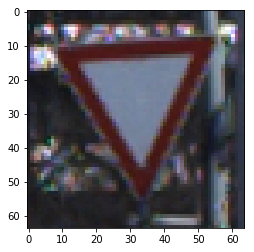

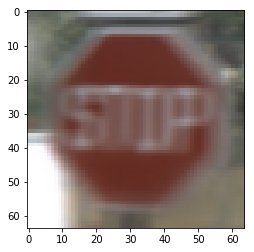

In [11]:
alteredImg = _noise(img)
plt.imshow(alteredImg)
plt.show()
alteredRemoteImg = _softSmooth(remoteImg)
plt.imshow(alteredRemoteImg)
plt.show()

### Chaining
To produce variable alternation functions from bricks, we need two helpers:

1. compose: composes two functions to a single function
2. chain: composes every function in a list

These are more general approaches, where you have to follow the requirements ouf our bricks very closely. 

In [13]:
# Composes f(x)&g(x) -> f(g(x))
_compose = lambda g,h : lambda x : g(h(x))

# This methods sticks multiple alternation-functions to one
# Every method needs to be a monad, exactly taking one image and returning one image
def chain(fns):
    neutral = lambda x : x 
    for f in fns:
        neutral = _compose(neutral,f)
    return neutral

Let's create a simple alternation function and use it to close this chapter. 

**Important**: The functions are applied in reverse order. It's often required to normalize the image after altering it.

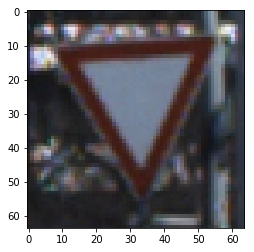

In [14]:
# Noise -> SoftSmooth -> Noise -> Normalize
alternation=chain([_normalize,_noise,_softSmooth,_noise])

alteredImg = alternation(img)
plt.imshow(alteredImg)
plt.show()

# Degeneration
After all the preparation we can finally come to the core-algorithm: the Degeneration. 

Requirements: 
* an image **ii**
* an alternation function 
* a maxdepth (not necessary)
* a maxloops (not necessary, strongly recommended)
* a threshold, how much the image can be worsened

Let's start with pseudocode:
0. Set depth=0, loop = 0
1. Take an Image **ii** and get initial score **is** from model
2. Set **i=ii** and **s=is**
3. Alter Image **i to Image ai**, increase loops by one
4. Rate **ai** and get score **as**
5. If **as>=s**-threshold
    1. Set **i = ai**
    2. Set **s = as**
    3. (Optional: Increase depth by one)
6. Repeat Step 3. until loops>=maxloops or depth==maxdepth
7. Return **i,s**

This Procedure is basicly model agnostic and can be used for different AI's and can be adapted for different datatypes (e.g. speech recognition models). 
It sometimes takes a while to produce good results. 

Additional we have two different sub-approaches:

Class-specific and non-class specific.

The difference is simple: We can focus on a single specific class. We do so in the local-degeneration. 

For our purposes it is a little slower in the alternation-success, and we did not want to slow down the remote degeneration any more. So for the remote-degeneration it is enough that **any** score is greater than the oldscore-threshold.

For the testing progress we have further added two functions:

* a verbose function, printing alternation progress live
* a plot function

The plot consists of the following elements:
1. Plotting the depth over time (to see the pace)
2. The scores over time (not only successes but any, to see the impact of the alternation)
3. Plotting the change-points (to see pace).It looks a little like a barcode: black means no change, white means change

In [15]:
def plotHistory(history):
    #Initate empty variables
    depths = []
    scores = []
    changes = []
    #iterate over the history which are tuples (score,depth)
    for i in range(len(history)):
        #make one list of the depth
        depths.append(history[i][1])
        #make one list of the scores
        scores.append(history[i][0])
        #make one list where we mark if a change happened
        changes.append(i>0 and depths[i-1]<depths[i])
    #We need that for the plot later
    changes = np.expand_dims(np.asarray(changes),0)
    ## Data prep completed: Now plot

    # Plot the Depth as a simple line
    # It's monoton so no worries here
    ax1 = plt.subplot(311)
    ax1.set_ylabel('Depth')
    plt.plot(depths)
    plt.setp(ax1.get_xticklabels(), visible=False)

    # Plot the recieved score, this is a strongly changing line
    ax2 = plt.subplot(312, sharex=ax1)
    ax2.set_ylabel('Score')
    plt.plot(scores)
    plt.setp(ax2.get_xticklabels(), visible=False)

    # Plot the changes
    # This will look like a barcode where white is a change, black is no change
    ax3 = plt.subplot(313)
    ax3.imshow(changes, aspect='auto', cmap=plt.cm.gray, interpolation='nearest')
    ax3.set_xlabel('Iteration')
    ax3.set_ylabel('Changed')
    plt.setp(ax3.get_xticklabels(), fontsize=12)

    plt.suptitle('History Summary')
    plt.show()

## Remote Degeneration 

In [16]:
############################### Remote #######################################
# This Methods runs Remote - the local Degeneration is beneath

# Method requires: 
#   An image (as 64x64x3 Uint8 Array), 
#   a function to alter the image,
#   a threshold how much the image can be worse by every step
#   The # of Iterations i want to (successfully) alter my image
#   The # of loops which i want to do max
# Scores an image, alters it, and keeps the altered image if its not that worse.
# Method logic will be documented in detail throughout the function
def remoteDegenerate(image, alternationfn = _noise, decay = 0.01, iterations = 10, maxloops=2000, verbose=True, history=True):
    # First: Check if the credentials are correct and the image is detected
    initialResp = Scorer.send_ppm_image(image)
    if(initialResp.status_code!=200):
        return
    # Initialise Start-Variables from our first score
    totalLoops = 0 #Counts all loops
    depth = 0 #Counts successfull loops
    lastImage = image
    lastScore = Scorer.get_best_score(initialResp.text)
    # To check if we put garbage in
    print("StartConfidence:",lastScore)

    if history:
        h = []    

    #We stop if we either reach our depth, or we exceed the maxloops
    while(depth<iterations and totalLoops<maxloops):
        totalLoops+=1
        # Alter the last image and score it
        degenerated = alternationfn(lastImage.copy())
        degeneratedResp = Scorer.send_ppm_image(degenerated)
        if (degeneratedResp.status_code==200):
            degeneratedScore= Scorer.get_best_score(degeneratedResp.text)
        else:
            print("Error, status code was: ", degeneratedResp.status_code)
            #Attempts do not count
            totalLoops-=1
        # if we verbose, we want console output (then we see directly if anything is not working)
        if verbose:
            print("Score:",degeneratedScore,"Depth:",depth, "Loop:" , totalLoops)
        # if we have history=True, we collect the same data as in verbose to plot something nice
        if history:
            h.append((degeneratedScore,depth,totalLoops))
        # If our score is acceptable (better than the set decay) we keep the new image and score
        if(degeneratedScore>=lastScore-decay):
            lastImage=degenerated
            lastScore=degeneratedScore
            depth+=1
        
        #We are working remote, we need to take a short break
        time.sleep(1.1)
    #We return the lastImg, this can be something not that good if we just reach maxloops!

    print("FinalConfidence:",lastScore)
    if h!=[] :
        plotHistory(h)
        return lastScore,lastImage,h
    else:
        return lastScore,lastImage

Playing with this degeneration needs a lot of feeling. However, there are some simple tips for starting:

* Idempotent Alternations are not that good - they will keep stuck if they're stuck
* Roughly estimate your decay * iterations
* You can usually abort if there was no change in the first 100 tries
* Don't pick items from the training set

Additional, keep in mind that there are stronger and weaker alternations. 10 Iterations of a strong alternation can yield much different results than 1000 Iterations of a weak noise. 

For conclusion we have added a simple example which should show some results. However, this will take 10 minutes!

StartConfidence: 0.97586221
Score: 0.97596484 Depth: 0 Loop: 1
Score: 0.9799999 Depth: 1 Loop: 2
Score: 0.98012275 Depth: 2 Loop: 3
Score: 0.97804284 Depth: 3 Loop: 4
Score: 0.97825968 Depth: 4 Loop: 5
Score: 0.97908825 Depth: 5 Loop: 6
Score: 0.98128498 Depth: 6 Loop: 7
Score: 0.98053324 Depth: 7 Loop: 8
Score: 0.9790414 Depth: 8 Loop: 9
Score: 0.97962672 Depth: 9 Loop: 10
Score: 0.97967827 Depth: 10 Loop: 11
Score: 0.97877103 Depth: 11 Loop: 12
Score: 0.97919822 Depth: 12 Loop: 13
Score: 0.97886777 Depth: 13 Loop: 14
Score: 0.97715819 Depth: 14 Loop: 15
Score: 0.9764623 Depth: 15 Loop: 16
Score: 0.97680515 Depth: 16 Loop: 17
Score: 0.97648686 Depth: 17 Loop: 18
Score: 0.97643071 Depth: 18 Loop: 19
Score: 0.97818941 Depth: 19 Loop: 20
Score: 0.97801626 Depth: 20 Loop: 21
Score: 0.9779374 Depth: 21 Loop: 22
Score: 0.97698158 Depth: 22 Loop: 23
Score: 0.97627717 Depth: 23 Loop: 24
Score: 0.97718346 Depth: 24 Loop: 25
Score: 0.97717404 Depth: 25 Loop: 26
Score: 0.9758606 Depth: 26 Loop: 

Score: 0.96533239 Depth: 215 Loop: 217
Score: 0.96614957 Depth: 216 Loop: 218
Score: 0.96306092 Depth: 217 Loop: 219
Score: 0.96312648 Depth: 218 Loop: 220
Score: 0.96147281 Depth: 219 Loop: 221
Score: 0.96308166 Depth: 220 Loop: 222
Score: 0.95814157 Depth: 221 Loop: 223
Score: 0.95983887 Depth: 222 Loop: 224
Score: 0.95899671 Depth: 223 Loop: 225
Score: 0.95587683 Depth: 224 Loop: 226
Score: 0.95968813 Depth: 225 Loop: 227
Score: 0.96589166 Depth: 226 Loop: 228
Score: 0.96613407 Depth: 227 Loop: 229
Score: 0.96098632 Depth: 228 Loop: 230
Score: 0.97072673 Depth: 228 Loop: 231
Score: 0.97221869 Depth: 229 Loop: 232
Score: 0.97073722 Depth: 230 Loop: 233
Score: 0.96903127 Depth: 231 Loop: 234
Score: 0.96926212 Depth: 232 Loop: 235
Score: 0.96860594 Depth: 233 Loop: 236
Score: 0.96779352 Depth: 234 Loop: 237
Score: 0.96450806 Depth: 235 Loop: 238
Score: 0.96377134 Depth: 236 Loop: 239
Score: 0.96428484 Depth: 237 Loop: 240
Score: 0.96279716 Depth: 238 Loop: 241
Score: 0.95928413 Depth: 

Score: 0.9519906 Depth: 385 Loop: 428
Score: 0.94963753 Depth: 386 Loop: 429
Score: 0.94562113 Depth: 387 Loop: 430
Score: 0.94647586 Depth: 388 Loop: 431
Score: 0.95644677 Depth: 389 Loop: 432
Score: 0.95232129 Depth: 390 Loop: 433
Score: 0.9497503 Depth: 391 Loop: 434
Score: 0.95030379 Depth: 392 Loop: 435
Score: 0.94902599 Depth: 393 Loop: 436
Score: 0.95017856 Depth: 394 Loop: 437
Score: 0.95040464 Depth: 395 Loop: 438
Score: 0.9473421 Depth: 396 Loop: 439
Score: 0.94497573 Depth: 397 Loop: 440
Score: 0.94338208 Depth: 398 Loop: 441
Score: 0.93250561 Depth: 399 Loop: 442
Score: 0.94304693 Depth: 399 Loop: 443
Score: 0.94436413 Depth: 400 Loop: 444
Score: 0.94853711 Depth: 401 Loop: 445
Score: 0.94661534 Depth: 402 Loop: 446
Score: 0.93110192 Depth: 403 Loop: 447
Score: 0.94590145 Depth: 403 Loop: 448
Score: 0.9405719 Depth: 404 Loop: 449
Score: 0.94025594 Depth: 404 Loop: 450
Score: 0.93196434 Depth: 404 Loop: 451
Score: 0.9452346 Depth: 404 Loop: 452
Score: 0.94580525 Depth: 405 L

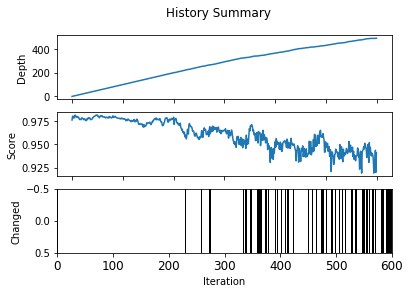

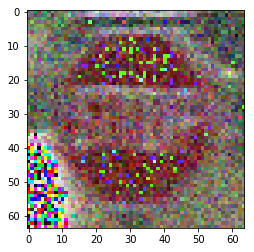

In [19]:
remoteAlternation = chain([_normalize,_noise])
ans = remoteDegenerate(remoteImg, remoteAlternation,verbose=True, iterations=600, maxloops=600,decay=0.005)
plt.imshow(ans[1])
plt.show()

## Local Degeneration
This example runs with the model *aphrodite* on your local machine. It's much faster than remote, but ... sadly is not the topic of the contest.

The local Degeneration requires the model in addition.

In [17]:
# This Degeneration runs for local Models
# Procedere is nearly the same as above
def degenerate (model, image, label, alternationfn = _noise, iterations=10, decay = 0.01, maxloops=2000,verbose=False,history=True):
    totalLoops = 0
    depth = 0
    lastScores,lastImage = Feeder.predict_single_image(model,image)
    lastLabelScore=lastScores[label]

    # To check if we put garbage in
    print("StartConfidence:",lastLabelScore)

    if history:
        h = []

    while(depth<iterations and totalLoops<maxloops):
        totalLoops+=1
        degenerated = alternationfn(lastImage.copy())
        degScores,degImage = Feeder.predict_single_image(model,degenerated)
        degLabelScore=degScores[label]

        if verbose:
            print("Score:",degLabelScore,"Depth:",depth, "Loop:" , totalLoops)
        if history:
            h.append((degLabelScore,depth))

        if(degLabelScore> lastLabelScore-decay):
            lastImage=degImage
            lastLabelScore=degLabelScore
            depth+=1
    if h!=[] :
        plotHistory(h)
        return lastLabelScore,lastImage,h
    else:
        return lastLabelScore,lastImage

Example:

StartConfidence: 1.0


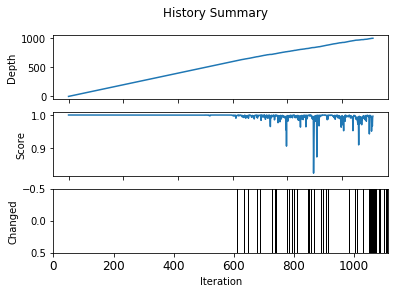

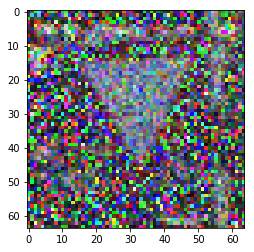

In [18]:
alternation = chain([_normalize,_noise,_softNoise])
ans = degenerate(aphrodite, img, bestClass, alternation, decay=0.004, iterations=1000, maxloops=3000,verbose=False,history=True)
#scipyMisc.imsave("images/localDegenerated.png",ans[1])
plt.imshow(ans[1])

### Batch-Degeneration
This is a variation of the local Degeneration, using batches instead of single images. 

In [31]:
def batchdegenerate (model, image, label, alternationfn = _noise, iterations=10, batchsize=50, decay = 0.01, maxloops=2000,verbose=False,history=True):
    totalLoops = 0
    depth = 0   
    lastScores,lastImage = Feeder.predict_single_image(model,image)
    lastLabelScore=lastScores[label]
    print("StartConfidence:",lastLabelScore)
    if history:
        h = []

    while(depth<iterations and totalLoops<maxloops):
        totalLoops+=1
        #########################################################
        # Here start the mass-degeneration-changes!
        #########################################################
        
        # degenerate the image batchsize-times and store as array
        degenerated = np.asarray([alternationfn(lastImage.copy()) for i in range(batchsize)])
        # predict every degenerated image
        degScores = model.predict(degenerated)
        # filter the scores for the class we want
        degLabelScores= [scoreBatch[label] for scoreBatch in degScores]
        # argmax(degLabelScores) gives the index of the highest score - we pick the image and score accordingly
        degImage = degenerated[np.argmax(degLabelScores)]
        degLabelScore = degLabelScores[np.argmax(degLabelScores)]
        # Rest is absolutely the same as above
        if verbose:
            print("Score:",degLabelScore,"Depth:",depth, "Loop:" , totalLoops)
        if history:
            h.append((degLabelScore,depth))

        if(degLabelScore> lastLabelScore-decay):
            lastImage=degImage
            lastLabelScore=degLabelScore
            depth+=1
    if h!=[] :
        plotHistory(h)
        return lastLabelScore,lastImage,h
    else:
        return lastLabelScore,lastImage

Using noise-only-alternationfunctions, this method has a fair chance to always pick the image with the lowest change (so to say, automaticly picking the image which got the least-noise and therefore the least-altered image). 

This can be somewhat contraproductive, as on the other hand the batch-processing takes (much) longer and therefor should yield a stronger altered image. 

However, the scores achieved are much better and the history looks much more successful.

StartConfidence: 1.0


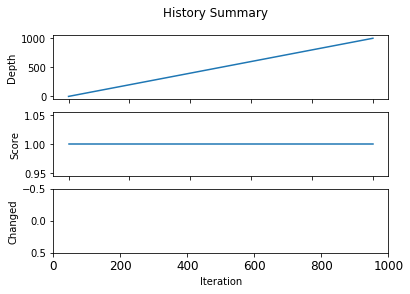

Wall time: 15min 21s


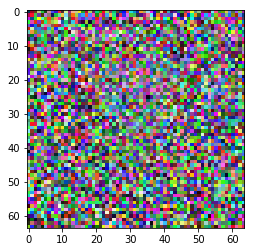

In [37]:
%%time
alternation = chain([_normalize,_noise,_softNoise,_noise,_softNoise,_noise,_softNoise])
ans = batchdegenerate(aphrodite, img, bestClass, alternation, decay=0.004,batchsize=20, iterations=1000, maxloops=4000,verbose=False,history=True)
#scipyMisc.imsave("images/localDegenerated.png",ans[1])
plt.imshow(ans[1])